In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, 
    Reshape, MultiHeadAttention, Add, LayerNormalization, 
    Flatten
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

2024-12-26 02:14:15.194578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 02:14:15.201146: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 02:14:15.219604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735197255.248191   51213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735197255.256467   51213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 02:14:15.285487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

[*********************100%***********************]  1 of 1 completed


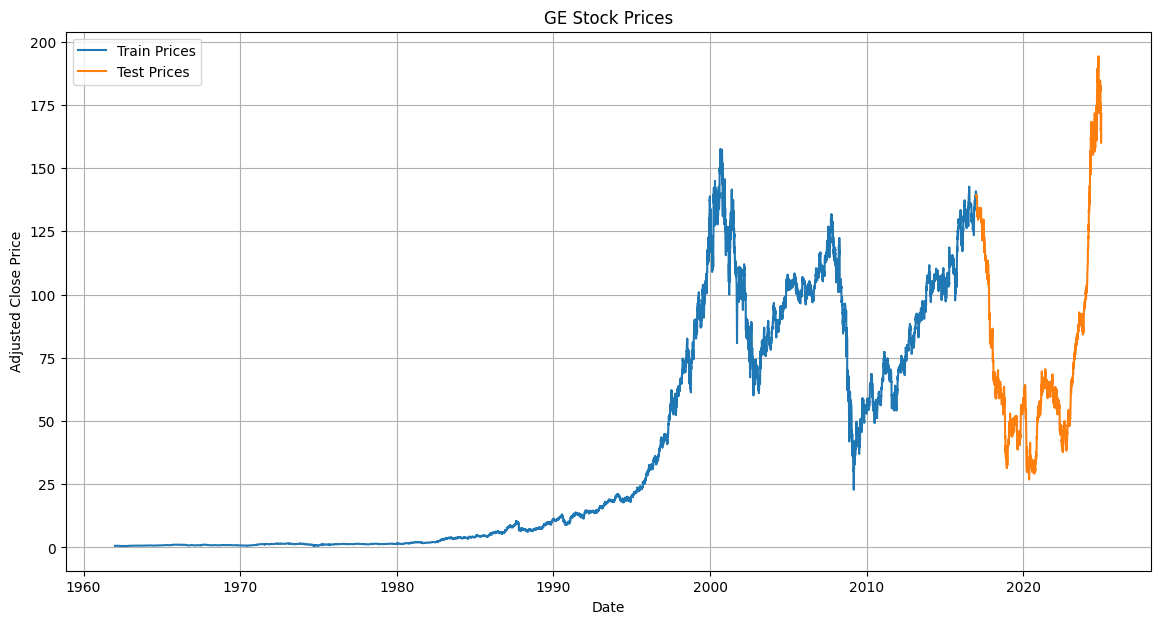

In [2]:
TKR = 'GE'
MAX_HOLDING = 100
MAX_HISTORY = 200
FEATURE_KERNEL_SIZES = [5, 10]
TEST_TRAIN_SPLIT = pd.Timestamp('2017-01-01')
TIME_EFFECT = 3

historic_prices = yf.download(TKR)['Adj Close']
train_prices, test_prices = historic_prices[TKR][:TEST_TRAIN_SPLIT].to_list(), historic_prices[TKR][TEST_TRAIN_SPLIT:].to_list()
plt.figure(figsize=(14, 7))
plt.plot(historic_prices[TKR][:TEST_TRAIN_SPLIT], label='Train Prices')
plt.plot(historic_prices[TKR][TEST_TRAIN_SPLIT:], label='Test Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{TKR} Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
outlook = []
for pos1 in range(len(train_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (train_prices[pos1 + pos2] - train_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / integrated_time_effect[TIME_EFFECT])
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)

In [4]:
features = get_sma_sd_v(train_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)[:-MAX_HOLDING - 1]
n_outlook = n_outlook[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)
y = np.array(n_outlook)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    inputs = tf.keras.layers.Input(shape=(len(x_train[0]),))
    
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    residual_1 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_1])
    
    residual_2 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_2])
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x)
    
    return tf.keras.models.Model(inputs, outputs)

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='mean_absolute_error')

W0000 00:00:1735197265.894343   51213 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=30, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 0.6527 - val_loss: 0.3295
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 0.4332 - val_loss: 0.3431
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.3620 - val_loss: 0.3219
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.3422 - val_loss: 0.3253
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 0.3393 - val_loss: 0.3281
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 0.3351 - val_loss: 0.3260
Epoch 7/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.3270 - val_loss: 0.3238
Epoch 8/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.3223 - val_loss: 0.3213
Epoch 9/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.3304 - val_loss: 0.3188
Epoch 10/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.3244 - val_loss: 0.3202
Epoch 11/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - loss: 0.3273 - val_loss: 0.3230
Epoch 12/30
339/339 ━━━━━━━━━━

In [7]:
features = get_sma_sd_v(test_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)
test_prices = test_prices[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)

p_outlook = model.predict(x)
p_outlook = [x[0] for x in p_outlook]

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [8]:
account = Account()
stock = Stock(TKR, test_prices[0])
MAX_TRANSACTION = 1

buy_positions = []
sell_positions = []
executed_sell_orders = []
executed_cover_orders = []

net_worth = []
min_balance = 0

for pos in range(len(test_prices)):
    stock.update_price(test_prices[pos])
    
    if p_outlook[pos] > 0.2:
        account.buy(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        buy_positions.append((pos, test_prices[pos]))
    elif p_outlook[pos] < -0.2:
        account.sell(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        sell_positions.append((pos, test_prices[pos]))
    
    net_worth.append(float(account.net_worth()))
    if account.balance < min_balance:
        min_balance = account.balance

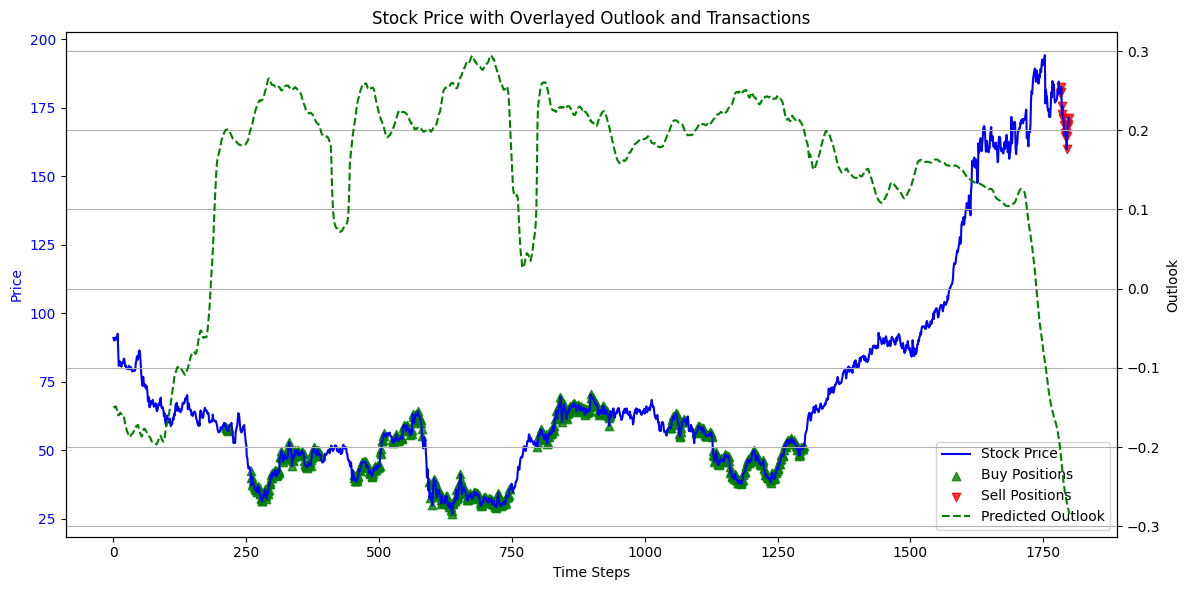

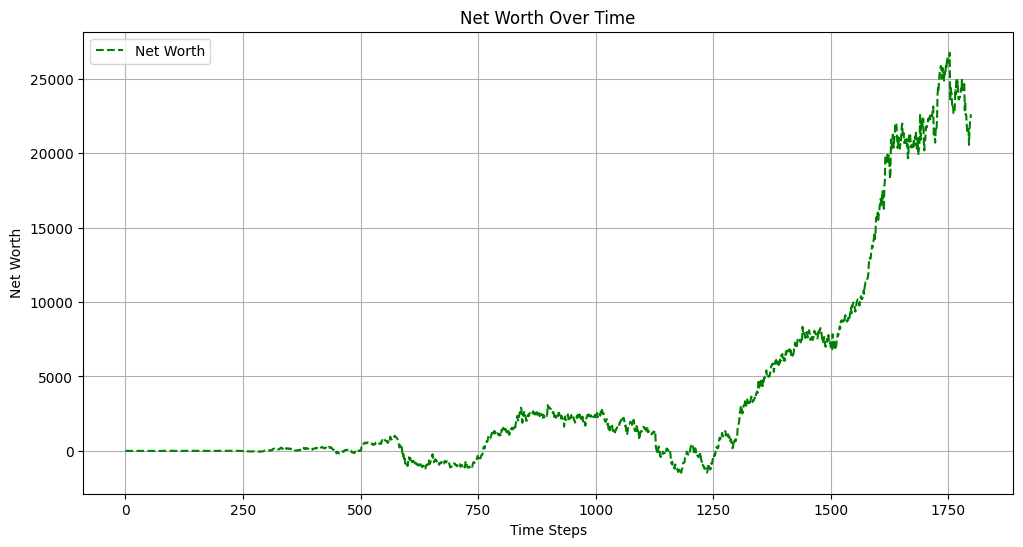

Balance: $-7833.73
Net Worth: $22611.88
Total Profit: 264.40%
Holdings:
GE: 177.53578186035156 shares
Stock Profit: 88.34%


In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(test_prices)), test_prices, label="Stock Price", color="blue")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

buy_x, buy_y = zip(*buy_positions) if buy_positions else ([], [])
ax1.scatter(buy_x, buy_y, label="Buy Positions", color="green", marker="^", alpha=0.8)

sell_x, sell_y = zip(*sell_positions) if sell_positions else ([], [])
ax1.scatter(sell_x, sell_y, label="Sell Positions", color="red", marker="v", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(range(len(p_outlook)), p_outlook, label="Predicted Outlook", color="green", linestyle="--")
ax2.set_ylabel("Outlook", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Stock Price with Overlayed Outlook and Transactions")
plt.grid()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(net_worth)), net_worth, label="Net Worth", color="green", linestyle="--")

plt.title("Net Worth Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.grid()

plt.show()

print(account)
print(f"Stock Profit: {(test_prices[-1] - test_prices[0]) / test_prices[0] * 100:.2f}%")